## Bok Photometric Analysis

This notebook examines the photometric reliability of the Bok data using repeat measurements of SDSS standard stars. For each reference star the mean and rms magnitudes are calculated from all individual measurements. The reference stars are then grouped into bins of magnitude. The distribution of the rms values (the photometric scatter) within the magnitude bins gives an indication of the photometric reliability.

First, some preliminaries:

In [2]:
%pylab inline
from matplotlib import ticker
import os,sys
sys.path.append('../bok')
from collections import OrderedDict
from astropy.table import Table,join
from astropy.stats import sigma_clip
import bokrmphot
_ = os.environ.setdefault('BOKRMDIR','../bok')

Populating the interactive namespace from numpy and matplotlib


Load a photometric statistics table. This table contains the statistics of the photometry within magnitude bins. The "season" keyword restricts the data to a single observing season, so that the statistics can be compared between seasons. The resulting table is saved to a FITS file so that it can be reloaded later.

In [3]:
def load_pstable(psTabFn,photRun=None,season='2014',**kwargs):
    if not os.path.exists(psTabFn):
        psTab = bokrmphot.binned_phot_stats(photRun,season=season,**kwargs)
        psTab.write(psTabFn)
    psTab = Table.read(psTabFn)
    for c in psTab.colnames:
        if c.startswith('sig'):
            psTab[c].format = "{:.4f}"
        elif c=='outlierFrac':
            psTab[c].format = "{:.5f}"
    return psTab

Plot the results from the photometric statistics table. A central line shows the median rms within magnitude bins, and a shaded region shows the inter-quartile range of the rms. I.e., half of all reference stars at a given magnitude had an rms value less than the median line.

In [40]:
def plot_compare_scatters(psTabs,labels,colors='rgbcymk',filt='g',ax=None,units='mag',sfx=None):
    if sfx is None:
        sfx = ['','']
    def _append_arr(arr):
        return arr
        # used this for drawstyle=steps-post, but no equiv. for fill_between
        #return np.concatenate([arr,[arr[-1]]])
    if units=='mag':
        mscl = 1.0
    elif units=='mmag':
        mscl = 1e3
    if ax is None:
        figure()
        ax = subplot(111)
    for tab,l,c,_sfx in zip(psTabs,labels,colors,sfx):
        ax.fill_between(tab['mbins'],_append_arr(mscl*tab['sig%s25'%_sfx]),
                        _append_arr(mscl*tab['sig%s75'%_sfx]),
                        edgecolor='none',color=c,alpha=0.5)
        ax.plot(tab['mbins'],_append_arr(mscl*tab['sig%s50'%_sfx]),color=c,lw=1.5,label=l)
    legend(loc='upper left')
    xlabel('%s magnitude' % filt)
    ylabel('per-object std [%s]'%units)
    xlim(17,19)

## Comparing some early 2014 reductions

The next set of photometric statistics come from some early reductions of the first-year Bok data. **Nov2015g** was an early run of [bokpipe](https://github.com/legacysurvey/rapala/wiki/bokpipe). Note that the first round of difference imaging was based on an IDL  [pipeline](https://trac.sdss3.org/browser/repo/sdssrm/bokrm); the associated catalogs are versioned 20140905 and have an asymptotic scattter of ~2.5% in g band, much worse than the bokpipe runs. **Jan2017** and **Feb2017** were subsequent runs with incremental improvements; the changes can be recovered from the git repository.

In [3]:
psNov2015g = load_pstable('../phot_stats_Nov2015g.fits')
print psNov2015g['mbins','sig50','sig50Clip','outlierFrac']

mbins sig50  sig50Clip outlierFrac
----- ------ --------- -----------
 17.0 0.0174    0.0144     0.00179
 17.2 0.0207    0.0162     0.00156
 17.4 0.0237    0.0172     0.00162
 17.6 0.0194    0.0170     0.00135
 17.8 0.0217    0.0177     0.00133
 18.0 0.0289    0.0193     0.00183
 18.2 0.0275    0.0207     0.00174
 18.4 0.0300    0.0238     0.00150
 18.6 0.0295    0.0239     0.00136
 18.8 0.0337    0.0279     0.00175
 19.0 0.0380    0.0318     0.00176


In [4]:
psJan2017g = load_pstable('../phot_stats_Jan2017g.fits')
print psJan2017g['mbins','sig50','sig50Clip','outlierFrac']

mbins sig50  sig50Clip outlierFrac
----- ------ --------- -----------
 17.0 0.0106    0.0106     0.00003
 17.2 0.0110    0.0110     0.00018
 17.4 0.0114    0.0114     0.00004
 17.6 0.0120    0.0120     0.00019
 17.8 0.0120    0.0119     0.00012
 18.0 0.0134    0.0134     0.00012
 18.2 0.0142    0.0141     0.00016
 18.4 0.0155    0.0154     0.00017
 18.6 0.0178    0.0178     0.00017
 18.8 0.0197    0.0195     0.00028
 19.0 0.0229    0.0229     0.00022


In [5]:
psFeb2017g = load_pstable('../phot_stats_Feb2017g.fits')
print psFeb2017g['mbins','sig50','sig50Clip','outlierFrac']

mbins sig50  sig50Clip outlierFrac
----- ------ --------- -----------
 17.0 0.0107    0.0107     0.00000
 17.2 0.0112    0.0112     0.00006
 17.4 0.0115    0.0115     0.00000
 17.6 0.0118    0.0118     0.00010
 17.8 0.0121    0.0120     0.00011
 18.0 0.0133    0.0133     0.00011
 18.2 0.0142    0.0142     0.00012
 18.4 0.0156    0.0156     0.00011
 18.6 0.0178    0.0178     0.00016
 18.8 0.0195    0.0194     0.00026
 19.0 0.0228    0.0227     0.00017


In [6]:
psJan2017i = load_pstable('../phot_stats_Jan2017i.fits')
print psJan2017i['mbins','sig50','sig50Clip','outlierFrac']

mbins sig50  sig50Clip outlierFrac
----- ------ --------- -----------
 17.0 0.0201    0.0201     0.00002
 17.2 0.0201    0.0201     0.00004
 17.4 0.0207    0.0207     0.00001
 17.6 0.0213    0.0213     0.00001
 17.8 0.0221    0.0221     0.00006
 18.0 0.0231    0.0231     0.00000
 18.2 0.0247    0.0247     0.00004
 18.4 0.0268    0.0267     0.00008
 18.6 0.0294    0.0294     0.00003
 18.8 0.0322    0.0322     0.00005
 19.0 0.0366    0.0366     0.00007


In [7]:
psFeb2017i = load_pstable('../phot_stats_Feb2017i.fits')
print psFeb2017i['mbins','sig50','sig50Clip','outlierFrac']

mbins sig50  sig50Clip outlierFrac
----- ------ --------- -----------
 17.0 0.0190    0.0190     0.00080
 17.2 0.0192    0.0192     0.00077
 17.4 0.0196    0.0195     0.00080
 17.6 0.0205    0.0203     0.00076
 17.8 0.0212    0.0212     0.00070
 18.0 0.0225    0.0224     0.00074
 18.2 0.0243    0.0240     0.00086
 18.4 0.0264    0.0261     0.00076
 18.6 0.0290    0.0287     0.00073
 18.8 0.0320    0.0317     0.00073
 19.0 0.0367    0.0361     0.00064


The improvement from the **Nov2015g** to **Jan2017g** versions is significant.

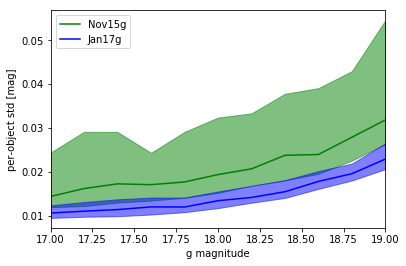

In [9]:
plot_compare_scatters([psNov2015g,psJan2017g],['Nov15g','Jan17g'],'gb')

Not much improvement in the **Feb2017g** version.

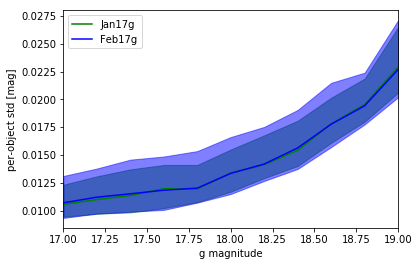

In [10]:
plot_compare_scatters([psJan2017g,psFeb2017g],['Jan17g','Feb17g'],'gb')

The scatter increases significantly if fainter stars are included in the zeropoint. Going from mag$<19.5$ to mag$<20.5$ more than doubles the scatter. Do not understand why this is...

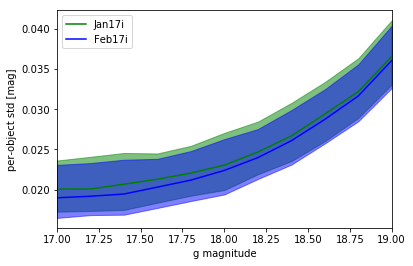

In [11]:
plot_compare_scatters([psJan2017i,psFeb2017i],['Jan17i','Feb17i'],'gb')

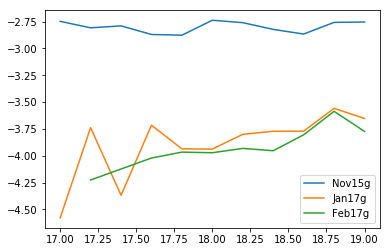

In [14]:
for psTab,l in zip([psNov2015g,psJan2017g,psFeb2017g],['Nov15g','Jan17g','Feb17g']):
    ii = where(psTab['outlierFrac']>0)[0]
    plot(psTab['mbins'][ii],log10(psTab['outlierFrac'][ii]),label=l)
legend()

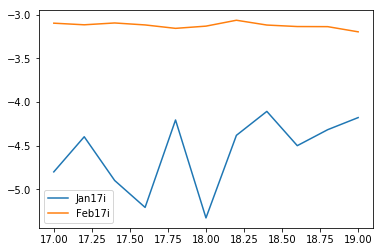

In [15]:
for psTab,l in zip([psJan2017i,psFeb2017i],['Jan17i','Feb17i']):
    ii = where(psTab['outlierFrac']>0)[0]
    plot(psTab['mbins'][ii],log10(psTab['outlierFrac'][ii]),label=l)
legend()

## 2015/6 data

**Jul2017** is the first processing run to include 2015 and 2016 data. The 2014 data was also reprocessed to include all changes to that point. Mainly the improvements were in handling the illumination correction.

In [5]:
procJul2017 = OrderedDict()
for season in ['2014','2015','2016']:
    procJul2017[season] = load_pstable('../archive/summer_2017/phot_stats_%sg_v2.fits'%season,
                                       'cleanstars',season,catdir='../archive/summer_2017/')
    print season
    print procJul2017[season]['mbins','sig50','outlierFrac']

2014
mbins sig50  outlierFrac
----- ------ -----------
 17.0 0.0111     0.00221
 17.2 0.0115     0.00284
 17.4 0.0118     0.00284
 17.6 0.0125     0.00217
 17.8 0.0125     0.00251
 18.0 0.0137     0.00220
 18.2 0.0146     0.00198
 18.4 0.0162     0.00202
 18.6 0.0182     0.00200
 18.8 0.0203     0.00193
 19.0 0.0237     0.00176
2015
mbins sig50  outlierFrac
----- ------ -----------
 17.0 0.0162     0.00248
 17.2 0.0165     0.00291
 17.4 0.0169     0.00391
 17.6 0.0182     0.00238
 17.8 0.0184     0.00255
 18.0 0.0193     0.00238
 18.2 0.0212     0.00218
 18.4 0.0227     0.00222
 18.6 0.0253     0.00232
 18.8 0.0285     0.00217
 19.0 0.0329     0.00208
2016
mbins sig50  outlierFrac
----- ------ -----------
 17.0 0.0160     0.00372
 17.2 0.0162     0.00385
 17.4 0.0163     0.00492
 17.6 0.0169     0.00390
 17.8 0.0172     0.00448
 18.0 0.0179     0.00428
 18.2 0.0195     0.00390
 18.4 0.0209     0.00360
 18.6 0.0235     0.00350
 18.8 0.0257     0.00420
 19.0 0.0300     0.00367


Comparing the results for the three observing seasons. The 2014 data has less scatter, possibly because there are more data and the sky flats are more accurate.

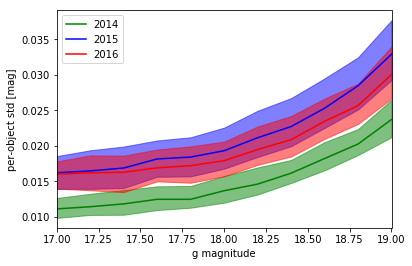

In [7]:
plot_compare_scatters(procJul2017.values(),procJul2017.keys(),'gbr')

## bokpipe_v0.3.0

The processing version used for the second round of difference imaging is bokpipe_v0.3.0, which was completed in **Oct2017**. The results from this run are shown below.

In [20]:
procOct2017 = OrderedDict()
for season in ['2014','2015','2016','2017']:
    procOct2017[season] = load_pstable('../archive/october_2017/phot_stats_%sg_v2.fits'%season,
                                       'cleanstars',season,catdir='../archive/october_2017/')
    print season
    print procOct2017[season]['mbins','sig50','outlierFrac']

2014
mbins sig50  outlierFrac
----- ------ -----------
 17.0 0.0084     0.00464
 17.2 0.0088     0.00501
 17.4 0.0092     0.00486
 17.6 0.0100     0.00416
 17.8 0.0107     0.00401
 18.0 0.0121     0.00373
 18.2 0.0127     0.00300
 18.4 0.0146     0.00358
 18.6 0.0167     0.00309
 18.8 0.0190     0.00319
 19.0 0.0223     0.00301
2015
mbins sig50  outlierFrac
----- ------ -----------
 17.0 0.0118     0.00561
 17.2 0.0125     0.00544
 17.4 0.0129     0.00580
 17.6 0.0145     0.00458
 17.8 0.0154     0.00441
 18.0 0.0173     0.00444
 18.2 0.0192     0.00381
 18.4 0.0211     0.00372
 18.6 0.0247     0.00472
 18.8 0.0284     0.00408
 19.0 0.0339     0.00363
2016
mbins sig50  outlierFrac
----- ------ -----------
 17.0 0.0124     0.00664
 17.2 0.0131     0.00597
 17.4 0.0128     0.00628
 17.6 0.0140     0.00605
 17.8 0.0146     0.00603
 18.0 0.0163     0.00610
 18.2 0.0177     0.00581
 18.4 0.0193     0.00549
 18.6 0.0224     0.00666
 18.8 0.0256     0.00606
 19.0 0.0298     0.00620
2017
mbins

This compares the **Oct2017** processing to the **Jul2017** processing. The main improvement was in cleaning up some gain correction errors, and fixing a long-standing bug where the zeropoints were based on an aperture (15 pixel) that subsequently had an aperture correction applied. A change was made to apply the correction to the zeropoint. Now the 2014 data reach sub-1% repeatability at $g<17.7$!

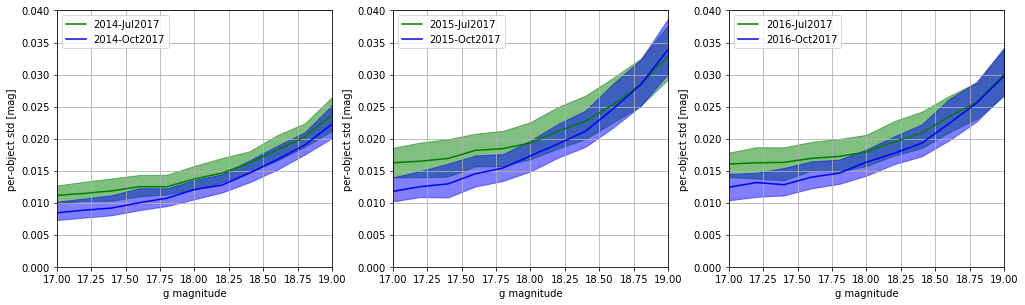

In [21]:
figure(figsize=(14,4))
subplots_adjust(0.05,0.1,0.99,0.99,0.22)
for pnum,season in enumerate(['2014','2015','2016'],start=1):
    ax = subplot(1,3,pnum)
    plot_compare_scatters([procJul2017[season],procOct2017[season]],
                          [season+'-Jul2017',season+'-Oct2017'],'gb',ax=ax)
    ax.set_ylim(0,0.04)
    ax.grid()

Again comparing the four seasons. The 2017 data mainly have 300s exposure times, whereas previous years mainly had 150s exposures.

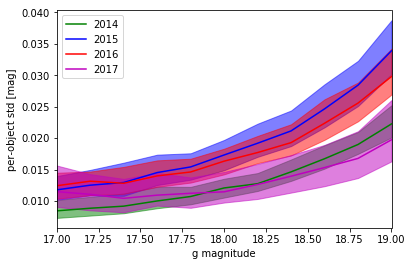

In [15]:
plot_compare_scatters(procOct2017.values(),procOct2017.keys(),'gbrm')

And now the i-band:

In [22]:
procOct2017i = OrderedDict()
for season in ['2014','2015','2016','2017']:
    procOct2017i[season] = load_pstable('../archive/october_2017/phot_stats_%si_v2.fits'%season,
                                       'cleanstars',season,band='i',
                                       catdir='../archive/october_2017/')
    print season
    print procOct2017i[season]['mbins','sig50','outlierFrac']

2014
mbins sig50  outlierFrac
----- ------ -----------
 17.0 0.0124     0.01441
 17.2 0.0129     0.01499
 17.4 0.0136     0.01436
 17.6 0.0142     0.01351
 17.8 0.0156     0.01281
 18.0 0.0172     0.01293
 18.2 0.0191     0.01278
 18.4 0.0224     0.01157
 18.6 0.0252     0.01060
 18.8 0.0292     0.00978
 19.0 0.0340     0.00948
2015
mbins sig50  outlierFrac
----- ------ -----------
 17.0 0.0128     0.02416
 17.2 0.0143     0.02388
 17.4 0.0148     0.02346
 17.6 0.0161     0.02356
 17.8 0.0184     0.02226
 18.0 0.0191     0.02184
 18.2 0.0193     0.02193
 18.4 0.0230     0.02194
 18.6 0.0263     0.02028
 18.8 0.0302     0.01864
 19.0 0.0356     0.01706
2016
mbins sig50  outlierFrac
----- ------ -----------
 17.0 0.0244     0.02484
 17.2 0.0263     0.02533
 17.4 0.0245     0.02338
 17.6 0.0399     0.02421
 17.8 0.0267     0.02349
 18.0 0.0327     0.02431
 18.2 0.0268     0.02351
 18.4 0.0345     0.02369
 18.6 0.0360     0.02230
 18.8 0.0393     0.02273
 19.0 0.0442     0.02132
2017
mbins

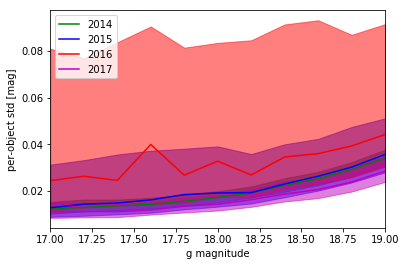

In [23]:
plot_compare_scatters(procOct2017i.values(),procOct2017.keys(),'gbrm')

So the 2016 i-band data has some issues...

## self-calibration

As a shortcut to solving the full ubercalibration problem (even with a large number of repeats the Bok data have been found to be somewhat noisy for recovering ubercal parameters), a `selfcal()` routine was implemented that assumes the extinction parameters from SDSS and uses them to derive per-image zeropoints from the mean magnitude offsets. The above results were all based on zeropoints obtained from external calibration using SDSS; the following results come from the selfcal procedure which provides zeropoints on an internal Bok system.

In [16]:
class NewBinnedStats(object):
    def __init__(self,tabf):
        self.tab = Table.read(tabf)
    def get(self,season,filt):
        i = where((self.tab['season']==season)&(self.tab['filter']==filt))[0][0]
        rv = Table()
        rv['mbins'] = array(self.tab.meta['MBINS'].split(',')).astype(float)
        for k in self.tab.colnames:
            if k.startswith('sig'):
                rv[k] = self.tab[k][i]
        return rv

In [28]:
oct17noselfcal = NewBinnedStats('../archive/october_2017/phot_stats_oct17noselfcal.fits')
oct17selfcal = NewBinnedStats('../archive/october_2017/phot_stats_oct17.fits')

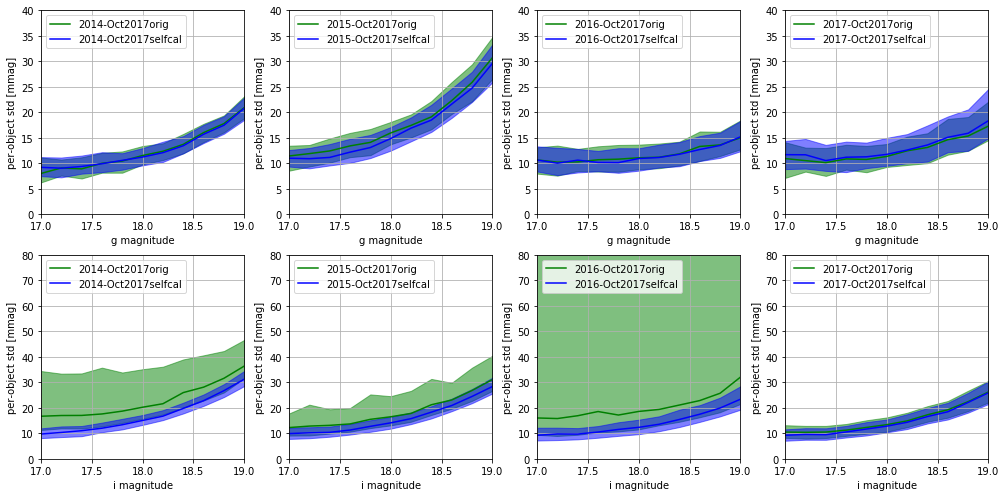

In [35]:
figure(figsize=(14,7))
subplots_adjust(0.05,0.1,0.99,0.99,0.22)
pnum = 1
for b in 'gi':
    for season in ['2014','2015','2016','2017']:
        ax = subplot(2,4,pnum)
        plot_compare_scatters([oct17noselfcal.get(season,b),oct17selfcal.get(season,b)],
                              [season+'-Oct2017orig',season+'-Oct2017selfcal'],
                              'gb',filt=b,ax=ax,units='mmag')
        if b=='g':
            ax.set_ylim(0,40)
        else:
            ax.set_ylim(0,80)
        ax.grid()
        pnum += 1

selfcal has a small effect on g-band photometry (maybe slight improvement in 2015). But huge effect on i-band, and in particular addresses the weird scatter in the 2016 data. Now asymptotically reaching 10 mmag scatter at g,i=17.

Check the improvement by restricting to only photometric frames:

In [36]:
oct17selfcalphoto = NewBinnedStats('../archive/october_2017/phot_stats_oct17_photo.fits')

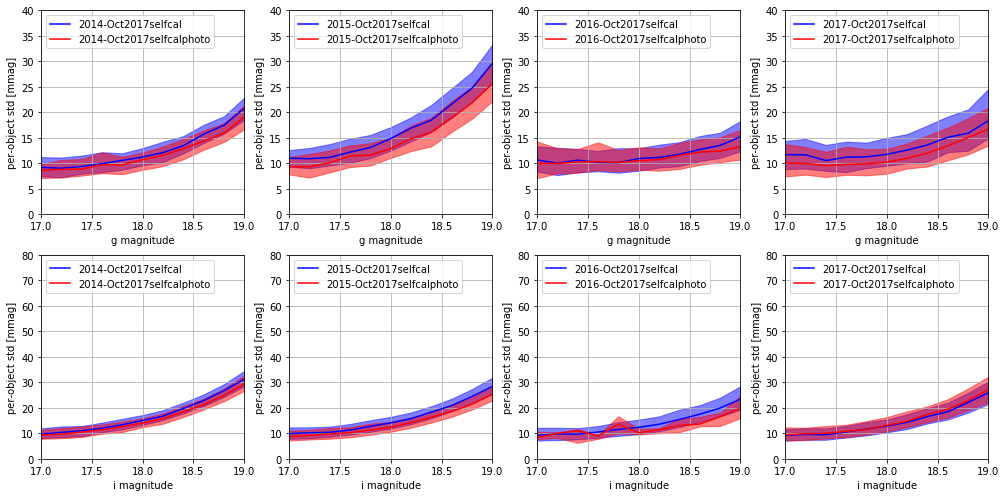

In [38]:
figure(figsize=(14,7))
subplots_adjust(0.05,0.1,0.99,0.99,0.22)
pnum = 1
for b in 'gi':
    for season in ['2014','2015','2016','2017']:
        ax = subplot(2,4,pnum)
        plot_compare_scatters([oct17selfcal.get(season,b),oct17selfcalphoto.get(season,b)],
                              [season+'-Oct2017selfcal',season+'-Oct2017selfcalphoto'],
                              'br',filt=b,ax=ax,units='mmag')
        if b=='g':
            ax.set_ylim(0,40)
        else:
            ax.set_ylim(0,80)
        ax.grid()
        pnum += 1

Finally, compare the internal calib with the external rms (Bok-SDSS):

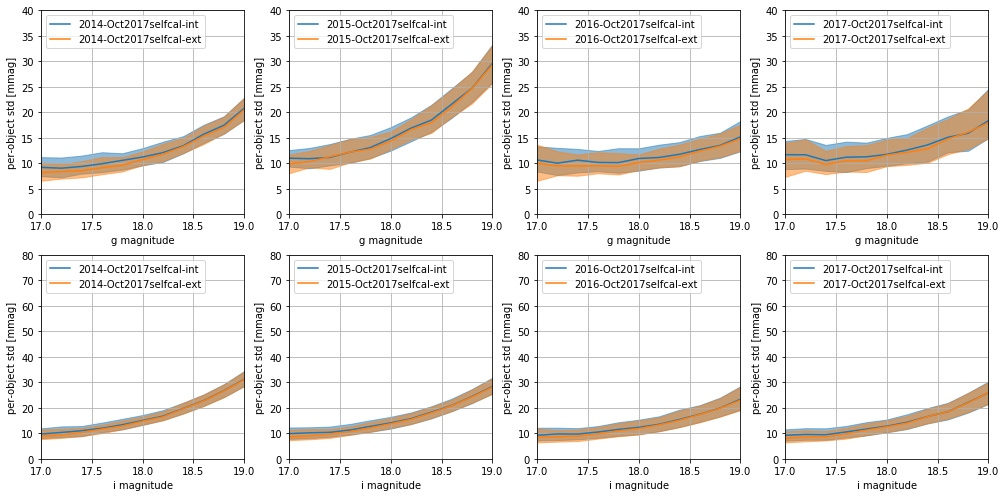

In [41]:
figure(figsize=(14,7))
subplots_adjust(0.05,0.1,0.99,0.99,0.22)
pnum = 1
for b in 'gi':
    for season in ['2014','2015','2016','2017']:
        ax = subplot(2,4,pnum)
        plot_compare_scatters([oct17selfcal.get(season,b),oct17selfcal.get(season,b)],
                              [season+'-Oct2017selfcal-int',season+'-Oct2017selfcal-ext'],
                              ['C0','C1'],filt=b,ax=ax,units='mmag',sfx=['','Ext'])
        if b=='g':
            ax.set_ylim(0,40)
        else:
            ax.set_ylim(0,80)
        ax.grid()
        pnum += 1